In [2]:
import os
os.listdir("/content")


['.config', 'True.csv.zip', 'Fake.csv.zip', 'sample_data']

In [3]:
from zipfile import ZipFile

with ZipFile("/content/True.csv.zip", "r") as zip_ref:
    zip_ref.extractall("/content")

with ZipFile("/content/Fake.csv.zip", "r") as zip_ref:
    zip_ref.extractall("/content")


In [4]:
import os
os.listdir("/content")


['.config',
 'Fake.csv.zip',
 'True.csv',
 'Fake.csv',
 'True.csv.zip',
 'sample_data']

In [5]:
import pandas as pd

true = pd.read_csv("/content/True.csv")
fake = pd.read_csv("/content/Fake.csv")

true.head(), fake.head()


(                                               title  \
 0  As U.S. budget fight looms, Republicans flip t...   
 1  U.S. military to accept transgender recruits o...   
 2  Senior U.S. Republican senator: 'Let Mr. Muell...   
 3  FBI Russia probe helped by Australian diplomat...   
 4  Trump wants Postal Service to charge 'much mor...   
 
                                                 text       subject  \
 0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
 1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
 2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
 3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
 4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
 
                  date  
 0  December 31, 2017   
 1  December 29, 2017   
 2  December 31, 2017   
 3  December 30, 2017   
 4  December 29, 2017   ,
                                                title  \
 0   Donald Trump Se

In [6]:
fake['label'] = 0   # FAKE
true['label'] = 1   # REAL

df = pd.concat([fake, true], axis=0)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [7]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [8]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
fake = pd.read_csv("/content/Fake.csv")
true = pd.read_csv("/content/True.csv")

fake['label'] = 0   # FAKE
true['label'] = 1   # REAL

df = pd.concat([fake, true])
df = df.sample(frac=1).reset_index(drop=True)

df.head()


,title,text,subject,date,label
0,Britain has not seen any evidence of successfu...,LONDON (Reuters) - Britain has not seen any ev...,worldnews,"November 14, 2017",1
1,HOLY CONTRACEPTION! Pope Francis Tells Latin A...,"And the hits just keep on coming, as the Pope ...",left-news,"Feb 18, 2016",0
2,Trump’s FCC Makes Major Move To Put His Propa...,"Sinclair Broadcast Group, the media empire res...",News,"August 7, 2017",0
3,Former minister for Argentina's Fernandez arre...,"BUENOS AIRES (Reuters) - Julio De Vido, an ex-...",worldnews,"October 25, 2017",1
4,China's Xi: stable development of China-U.S. e...,BEIJING (Reuters) - Continued stable developme...,politicsNews,"November 9, 2017",1


In [10]:
df.info()
df.isnull().sum()
df['label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


,count
label,
0,23481
1,21417


In [11]:
df['text_length'] = df['text'].apply(len)
df['text_length'].describe()


,text_length
count,44898.000000
mean,2469.109693
std,2171.617091
min,1.000000
25%,1234.000000
50%,2186.000000
75%,3105.000000
max,51794.000000


In [12]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)


In [13]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X = vectorizer.fit_transform(df['clean_text'])
y = df['label']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [15]:
fake_words = ["fake", "hoax", "conspiracy", "rumor", "clickbait"]

def rule_based_classifier(text):
    return 0 if any(word in text for word in fake_words) else 1

df['rule_pred'] = df['clean_text'].apply(rule_based_classifier)


In [16]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [17]:
print("Naive Bayes Results")
print(classification_report(y_test, nb.predict(X_test)))

print("Logistic Regression Results")
print(classification_report(y_test, lr.predict(X_test)))


Naive Bayes Results
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4696
           1       0.95      0.94      0.94      4284

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



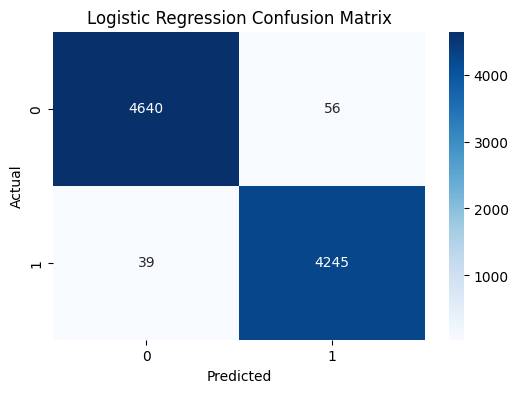

In [18]:
cm = confusion_matrix(y_test, lr.predict(X_test))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [19]:
plt.savefig("confusion_matrix.png")

with open("metrics.txt", "w") as f:
    f.write(classification_report(y_test, lr.predict(X_test)))


<Figure size 640x480 with 0 Axes>

In [20]:
from google.colab import files
files.download("confusion_matrix.png")
files.download("metrics.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>